# CCA in Pytorch from scratch

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

## Download simulated data

In [2]:
import requests
def download_data(url, filename):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
    else:
        print(f'Failed to download file: status code {response.status_code}')

fakepatient1_url = 'https://uni-bonn.sciebo.de/s/oRhgtUMcye9VcZu/download'
fakepatient2_url = 'https://uni-bonn.sciebo.de/s/NySxjD1zjNIjJCY/download'
download_data(fakepatient1_url, "fakepatient1.npy")
download_data(fakepatient2_url, "fakepatient2.npy")

## Load the data

In [3]:
# patient1 = np.load("patient1.npy")
# patient2 = np.load("patient2.npy")

patient1 = np.load("fakepatient1.npy")
patient2 = np.load("fakepatient2.npy")

In [4]:
patient1.shape, patient2.shape

((30, 5000), (50, 5000))

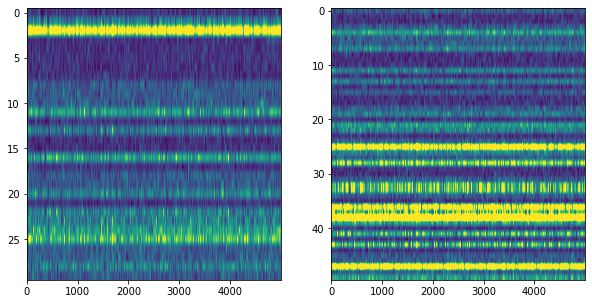

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(patient1, aspect="auto", vmin=0, vmax=2)
ax2.imshow(patient2, aspect="auto", vmin=0, vmax=2)

## Standardize (i.e. z-score) the data per neuron

In [6]:
patient1_train = patient1.T[:-700].astype(np.float32)
patient2_train = patient2.T[:-700].astype(np.float32)

mean1 = patient1_train.mean(axis=0, keepdims=True)
mean2 = patient2_train.mean(axis=0, keepdims=True)
std1 = patient1_train.std(axis=0, keepdims=True)
std2 = patient2_train.std(axis=0, keepdims=True)

patient1_train = (patient1_train - mean1) / std1
patient2_train = (patient2_train - mean2) / std2

patient1_test = patient1.T[-650:].astype(np.float32)
patient2_test = patient2.T[-650:].astype(np.float32)

patient1_test = (patient1_test - mean1) / std1
patient2_test = (patient2_test - mean2) / std2 

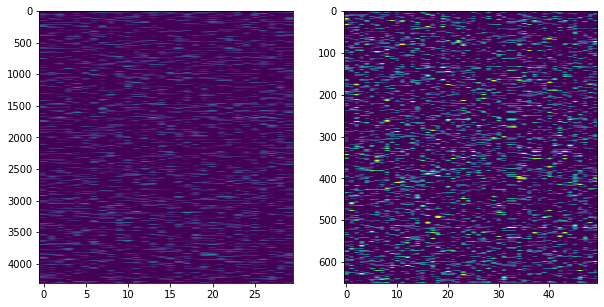

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(patient1_train, aspect="auto", vmin=0, vmax=2)
ax2.imshow(patient2_test, aspect="auto", vmin=0, vmax=2)

## Create Pytorch dataloaders

In [8]:
from torch.utils.data import TensorDataset, DataLoader

In [9]:
x_and_y_train = TensorDataset(
    torch.from_numpy(patient1_train).to(device), 
    torch.from_numpy(patient2_train).to(device)
)
trainloader = DataLoader(x_and_y_train, batch_size=512, shuffle=True)

x_and_y_test = TensorDataset(
    torch.from_numpy(patient1_test).to(device), 
    torch.from_numpy(patient2_test).to(device)
)
testloader = DataLoader(x_and_y_test, batch_size=512, shuffle=False)

#### Quick ckeck:

In [10]:
for x, y in trainloader:
    break
    
x.shape, y.shape

(torch.Size([512, 30]), torch.Size([512, 50]))

## Model

In [11]:
from torch import nn

class CCAModel(nn.Module):
    def __init__(self, data_dim, k):
        super().__init__()
        self.linear_mapping = nn.Linear(data_dim, k, bias=False)
        
    def forward(self, x):
        return self.linear_mapping(x)

#### Quick check:

In [12]:
k = 5

# Initialize a linear model for the mapping from X (domain 1) to U (latent for domain 1) 
x_dim = x.shape[1]
u_model = CCAModel(x_dim, k).to(device)

# Initialize a linear model for the mapping from Y (domain 2) to V (latent for domain 2)
y_dim = y.shape[1]
v_model = CCAModel(y_dim, k).to(device)

In [13]:
u = u_model(x)
v = v_model(y)

u.shape, v.shape

(torch.Size([512, 5]), torch.Size([512, 5]))

## Objective function

In [14]:
def cca_obj_only_diag(u, v, k):
    uv = torch.cat([u, v], dim=1)
    uv_corr_mat = torch.corrcoef(uv.T)[:k][:, k:]
    uv_corr_diag = uv_corr_mat.diag()
    return uv_corr_diag.mean() * -1 

In [15]:
def cca_obj_cross_covariance(u, v, k):
    device = u.device
    uv = torch.cat([u, v], dim=1)
    uv_corr_mat = torch.corrcoef(uv.T)[:k][:, k:]
    res = (uv_corr_mat - torch.eye(k).to(device))
    return torch.norm(res)**2

In [16]:
def cca_obj_complete_covariance(u, v, k):
    device = u.device
    uv = torch.cat([u, v], dim=1)
    uv_corr_mat = torch.corrcoef(uv.T)
    target_corr_mat = torch.eye(k).repeat(2, 2).to(device)
    res = (uv_corr_mat - target_corr_mat)
    return torch.norm(res)**2

## Train the CCA models

In [17]:
### Models
k = 5
x_dim = x.shape[1]
u_model = CCAModel(x_dim, k).to(device)
y_dim = y.shape[1]
v_model = CCAModel(y_dim, k).to(device)

### Training (on the train set)
num_epochs = 500
lr = 1e-3
params = list(u_model.parameters()) + list(v_model.parameters())
optimizer = torch.optim.Adam(params=params, lr=lr)

train_losses = []
u_model.train()
v_model.train()
pbar = tqdm(range(num_epochs), desc='Epochs')
for epoch in pbar:
    for x,y in trainloader:
        u = u_model(x)
        v = v_model(y)
#         loss = cca_obj_only_diag(u, v, k)
        loss = cca_obj_cross_covariance(u, v, k)
#         loss = cca_obj_complete_covariance(u, v, k)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_losses.append(loss.item())
    pbar.set_description(f'Loss: {loss.item():.4f}')
    
### Testing (on the test set)
u_model.eval()
v_model.eval()
u_test = u_model(torch.from_numpy(patient1_test).to(device))
v_test = v_model(torch.from_numpy(patient2_test).to(device))
test_loss = cca_obj_cross_covariance(u_test, v_test, k).item()
print(f"Test loss: {test_loss:.4f}")

Loss: 0.0770: 100% 500/500 [00:19<00:00, 25.12it/s]

Test loss: 0.0778


## Results

In [18]:
u_test = u_model(torch.from_numpy(patient1_test).to(device)).cpu().data.numpy()
v_test = v_model(torch.from_numpy(patient2_test).to(device)).cpu().data.numpy()

rect_block = np.concatenate([u_test, v_test], axis=1)
complete_corr_mat = np.corrcoef(rect_block.T)
uv_corr_mat = complete_corr_mat[:k][:, k:]

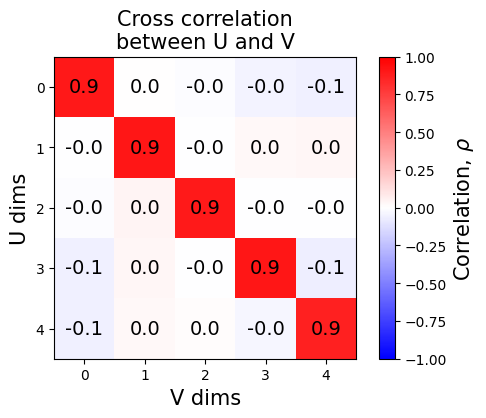

In [19]:
plt.figure(dpi=100)

plt.imshow(uv_corr_mat, vmin=-1, vmax=1, cmap="bwr") 
cbar = plt.colorbar()
plt.title("Cross correlation\nbetween U and V", fontsize=15);
plt.xlabel("V dims", fontsize=15)
plt.ylabel("U dims", fontsize=15)
cbar.set_label(r"Correlation, $\rho$", fontsize=15)

# Loop over data dimensions and create text annotations.
for i in range(uv_corr_mat.shape[0]):
    for j in range(uv_corr_mat.shape[1]):
        plt.text(j, i, f'{uv_corr_mat[i, j]:.1f}', ha="center", va="center", color="k", fontsize=14)

Text(2, 10.9, 'V dims')

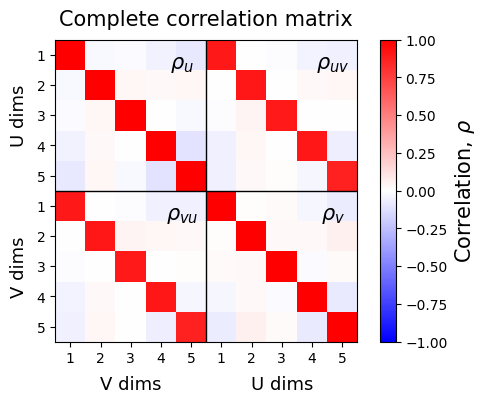

In [20]:
import matplotlib.lines as lines

fig = plt.figure(dpi=100)

plt.imshow(complete_corr_mat, vmin=-1, vmax=1, cmap="bwr") 
cbar = plt.colorbar()
plt.title("Complete correlation matrix", fontsize=15, y=1.02);
cbar.set_label(r"Correlation, $\rho$", fontsize=15)
plt.xticks(np.arange(2*k), labels=np.concatenate([np.arange(k)+1]*2))
plt.yticks(np.arange(2*k), labels=np.concatenate([np.arange(k)+1]*2))

plt.plot([k-.5, k-.5], [0-.5, 2*k-.5], lw=1, color="k")
plt.plot([0-.5, 2*k-.5], [k-.5, k-.5], lw=1, color="k")
plt.text(3.7, 0.3, r"$\rho_u$", ha="center", va="center", fontsize=15)
plt.text(8.7, 0.3, r"$\rho_{uv}$", ha="center", va="center", fontsize=15)
plt.text(3.7, 5.3, r"$\rho_{vu}$", ha="center", va="center", fontsize=15)
plt.text(8.7, 5.3, r"$\rho_v$", ha="center", va="center", fontsize=15)

plt.text(-1.7, 2, "U dims", ha="center", va="center", rotation="vertical", fontsize=13)
plt.text(-1.7, 7, "V dims", ha="center", va="center", rotation="vertical", fontsize=13)
plt.text(7, 10.9, "U dims", ha="center", va="center", rotation="horizontal", fontsize=13)
plt.text(2, 10.9, "V dims", ha="center", va="center", rotation="horizontal", fontsize=13)

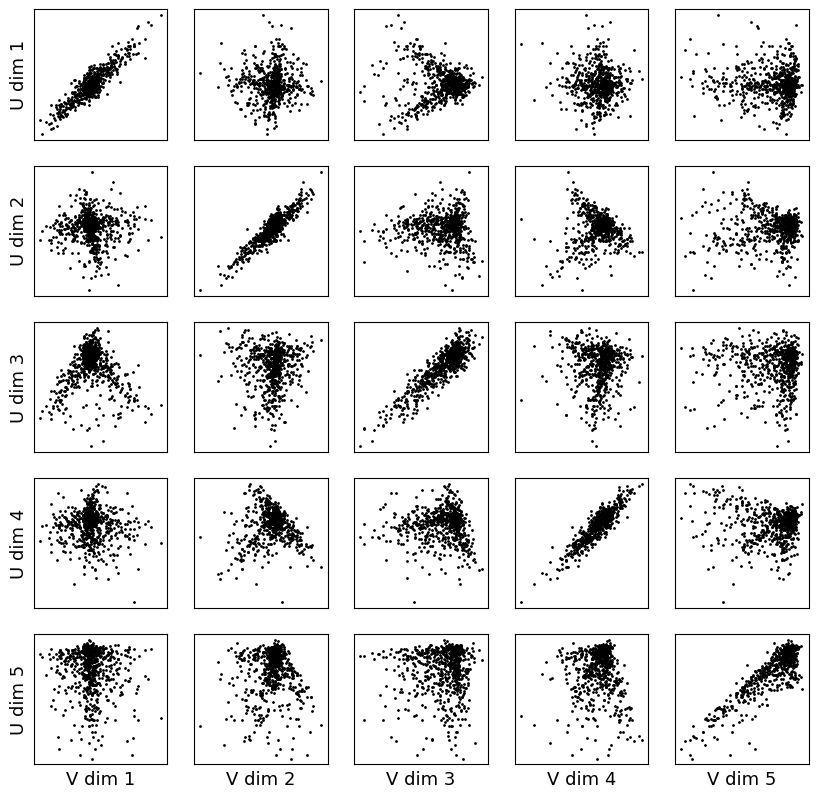

In [21]:
fig, axes = plt.subplots(k, k, figsize=(2*k, 2*k), dpi=100)

for udim_idx in range(k):
    for vdim_idx in range(k):
        ax = axes[udim_idx, vdim_idx]
        ax.scatter(v_test[:,vdim_idx], u_test[:,udim_idx], c="k", s=1)
        ax.set(xticks=[], yticks=[])
        
        if udim_idx == k-1:
            ax.set_xlabel(f"V dim {vdim_idx+1}", fontsize=13)
        
        if vdim_idx == 0:
            ax.set_ylabel(f"U dim {udim_idx+1}", fontsize=13)